# Notebook 04: Clasificacion de Nodulos Pulmonares

Este notebook entrena clasificadores de nodulos pulmonares (benigno/maligno) usando datos de LUNA16 + anotaciones LIDC-IDRI.

## Contenido:
1. **Extraccion de Patches**: Desde LUNA16 + LIDC-IDRI (no Kaggle)
2. **Modelos**: EfficientNet-B0 y DenseNet121
3. **Data Augmentation**: Rotacion, flip, zoom, brillo
4. **Comparacion**: Evaluacion de ambos modelos
5. **Metricas**: AUC, Precision, Recall, F1

---

## Datos

| Fuente | Descripcion |
|--------|-------------|
| LUNA16 | Imagenes CT (subset0-9, 888 scans) |
| LIDC-IDRI | Anotaciones de 4 radiologos con scores de malignidad (1-5) |

**Criterio de clasificacion:**
- Benigno (0): Malignancy score 1-2
- Maligno (1): Malignancy score 4-5
- Excluido: Score 3 (indeterminado)

---

## 1. Configuracion del Entorno

In [2]:
# Detectar entorno y configurar
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

# ============================================================
# CONFIGURACION
# ============================================================
SAVE_TO_DRIVE = True  # Guardar modelo en Drive (solo Colab)
SUBSETS_TO_USE = [0]  # Subsets de LUNA16 a usar [0] o [0,1,2,...,9]

if IN_COLAB:
    print("Ejecutando en Google Colab")
    print("="*50)
    
    # Instalar dependencias
    import subprocess
    paquetes = ['SimpleITK', 'pylidc', 'efficientnet_pytorch', 'timm']
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + paquetes)
    
    # Clonar repositorio
    repo_url = "https://github.com/Daspony/Imagenes-Biomedicas.git"
    if not os.path.exists("/content/Imagenes-Biomedicas"):
        subprocess.run(["git", "clone", repo_url], cwd="/content", check=True)
    sys.path.insert(0, "/content/Imagenes-Biomedicas")
    project_root = "/content/Imagenes-Biomedicas"
    
    # Montar Drive para guardar modelo
    if SAVE_TO_DRIVE:
        from google.colab import drive
        drive.mount('/content/drive')
        weights_dir = "/content/drive/MyDrive/lung_nodule_weights"
        os.makedirs(weights_dir, exist_ok=True)
        print(f"[OK] Pesos se guardaran en: {weights_dir}")
    else:
        weights_dir = os.path.join(project_root, 'weights')
else:
    print("Ejecutando localmente")
    print("="*50)
    parent_dir = os.path.abspath('..')
    if parent_dir not in sys.path:
        sys.path.insert(0, parent_dir)
    project_root = parent_dir
    weights_dir = os.path.join(project_root, 'weights')

os.makedirs(weights_dir, exist_ok=True)
print(f"Directorio de pesos: {weights_dir}")

Ejecutando localmente
Directorio de pesos: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights


In [3]:
# Importar librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import warnings
import json

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms
import timm  # Para EfficientNet y DenseNet

# Metricas
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# Utilidades del proyecto
from utils import LUNA16DataLoader, download_luna16
from utils.lidc_loader import LIDCAnnotationLoader

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nLibrerias importadas")

Dispositivo: cuda
GPU: NVIDIA GeForce RTX 2050

Librerias importadas


In [4]:
# ============================================================
# DETECTAR SUBSETS DISPONIBLES
# ============================================================
LUNA16_DIR = os.path.join(project_root, 'LUNA16')
ANNOTATIONS_PATH = os.path.join(LUNA16_DIR, 'annotations.csv')

# Detectar subsets disponibles automaticamente
available_subsets = []
for i in range(10):
    subset_path = os.path.join(LUNA16_DIR, f'subset{i}')
    if os.path.exists(subset_path):
        mhd_files = list(Path(subset_path).glob("*.mhd"))
        if len(mhd_files) > 0:
            available_subsets.append(i)
            print(f"[OK] subset{i}: {len(mhd_files)} scans")

if not available_subsets:
    print("[WARNING] No se encontraron subsets de LUNA16")
    print("Descargando subset0...")
    download_luna16(subsets=[0], download_dir=LUNA16_DIR)
    available_subsets = [0]

print(f"\nSubsets disponibles: {available_subsets}")
print(f"Total subsets: {len(available_subsets)}")

# Cargar anotaciones
if os.path.exists(ANNOTATIONS_PATH):
    annotations_df = pd.read_csv(ANNOTATIONS_PATH)
    print(f"Anotaciones LUNA16: {len(annotations_df)} nodulos")

[OK] subset0: 89 scans
[OK] subset1: 89 scans
[OK] subset2: 89 scans
[OK] subset3: 89 scans

Subsets disponibles: [0, 1, 2, 3]
Total subsets: 4
Anotaciones LUNA16: 1186 nodulos


---

## 2. Extraccion de Patches LUNA16 + LIDC

Extraemos patches de 64x64 pixeles centrados en cada nodulo, con etiquetas de malignidad de LIDC-IDRI.

**Criterio de binarizacion:**
- Score 1-2 -> Benigno (0)
- Score 4-5 -> Maligno (1)
- Score 3 -> Excluido (indeterminado)

In [5]:
class LUNALIDCPatchExtractor:
    """
    Extractor de patches de nodulos desde LUNA16 + LIDC-IDRI
    
    Extrae patches 2D centrados en nodulos con etiquetas de malignidad
    basadas en el consenso de radiologos de LIDC-IDRI.
    """
    
    def __init__(self, luna16_dir, subsets, patch_size=64, min_radiologists=3):
        """
        Args:
            luna16_dir: Directorio raiz de LUNA16
            subsets: Lista de subsets a usar (ej: [0] o [0,1,2,...,9])
            patch_size: Tamano del patch cuadrado (default: 64)
            min_radiologists: Minimo de radiologos para considerar un nodulo (default: 3)
        """
        self.luna16_dir = Path(luna16_dir)
        self.subsets = subsets
        self.patch_size = patch_size
        self.min_radiologists = min_radiologists
        
        # Inicializar LIDC loader
        self.lidc_loader = LIDCAnnotationLoader(verbose=False)
        
        # Recolectar todos los scans
        self.scan_paths = {}
        for subset_id in subsets:
            subset_path = self.luna16_dir / f'subset{subset_id}'
            if subset_path.exists():
                for mhd_file in subset_path.glob("*.mhd"):
                    seriesuid = mhd_file.stem
                    self.scan_paths[seriesuid] = mhd_file
        
        print(f"[OK] {len(self.scan_paths)} scans encontrados en {len(subsets)} subsets")
    
    def extract_all_patches(self, verbose=True):
        """
        Extrae todos los patches con etiquetas de malignidad
        
        Returns:
            patches: Lista de arrays (patch_size, patch_size)
            labels: Lista de etiquetas (0=benigno, 1=maligno)
            metadata: Lista de diccionarios con info adicional
        """
        patches = []
        labels = []
        metadata = []
        
        n_excluded = 0  # Score 3 (indeterminado)
        n_no_lidc = 0   # Sin anotaciones LIDC
        
        for seriesuid, mhd_path in tqdm(self.scan_paths.items(), 
                                         desc="Extrayendo patches",
                                         disable=not verbose):
            try:
                # Obtener nodulos con suficientes anotaciones
                reliable_clusters = self.lidc_loader.get_reliable_nodules(
                    seriesuid, min_annotations=self.min_radiologists
                )
                
                if not reliable_clusters:
                    n_no_lidc += 1
                    continue
                
                # Cargar CT
                import SimpleITK as sitk
                ct_itk = sitk.ReadImage(str(mhd_path))
                ct_array = sitk.GetArrayFromImage(ct_itk)
                spacing = np.array(ct_itk.GetSpacing())[::-1]  # (z, y, x)
                origin = np.array(ct_itk.GetOrigin())[::-1]    # (z, y, x)
                
                # Procesar cada nodulo
                for cluster in reliable_clusters:
                    # Obtener malignidad por consenso
                    mal_info = self.lidc_loader.get_cluster_malignancy(cluster)
                    mean_mal = mal_info['malignancy_mean']
                    
                    # Binarizar: 1-2 = benigno, 4-5 = maligno, 3 = excluir
                    if mean_mal <= 2.0:
                        label = 0  # Benigno
                    elif mean_mal >= 4.0:
                        label = 1  # Maligno
                    else:
                        n_excluded += 1
                        continue  # Excluir score ~3
                    
                    # Obtener centro del nodulo desde la mascara
                    result = self.lidc_loader.get_aligned_mask_for_cluster(
                        cluster, origin, spacing, ct_array.shape, threshold=0.5
                    )
                    
                    if result is None:
                        continue
                    
                    mask, bbox = result
                    
                    # Calcular centro del nodulo
                    z_center = (bbox[0].start + bbox[0].stop) // 2
                    y_center = (bbox[1].start + bbox[1].stop) // 2
                    x_center = (bbox[2].start + bbox[2].stop) // 2
                    
                    # Extraer patch 2D del slice central
                    patch = self._extract_patch(ct_array, z_center, y_center, x_center)
                    
                    if patch is not None:
                        patches.append(patch)
                        labels.append(label)
                        metadata.append({
                            'seriesuid': seriesuid,
                            'z': z_center,
                            'y': y_center,
                            'x': x_center,
                            'malignancy_mean': mean_mal,
                            'malignancy_std': mal_info['malignancy_std'],
                            'num_radiologists': mal_info['num_radiologists']
                        })
                        
            except Exception as e:
                if verbose:
                    print(f"[ERROR] {seriesuid}: {e}")
                continue
        
        if verbose:
            print(f"\n[OK] Extraccion completada:")
            print(f"    Patches extraidos: {len(patches)}")
            print(f"    Benignos (0): {sum(1 for l in labels if l == 0)}")
            print(f"    Malignos (1): {sum(1 for l in labels if l == 1)}")
            print(f"    Excluidos (score ~3): {n_excluded}")
            print(f"    Sin anotaciones LIDC: {n_no_lidc}")
        
        return np.array(patches), np.array(labels), metadata
    
    def _extract_patch(self, ct_array, z, y, x):
        """Extrae un patch 2D centrado en (z, y, x)"""
        half = self.patch_size // 2
        
        # Verificar limites
        if (z < 0 or z >= ct_array.shape[0] or
            y - half < 0 or y + half > ct_array.shape[1] or
            x - half < 0 or x + half > ct_array.shape[2]):
            return None
        
        patch = ct_array[z, y-half:y+half, x-half:x+half]
        
        if patch.shape != (self.patch_size, self.patch_size):
            return None
        
        return patch.astype(np.float32)


# Crear extractor
extractor = LUNALIDCPatchExtractor(
    luna16_dir=LUNA16_DIR,
    subsets=available_subsets,
    patch_size=64,
    min_radiologists=3
)

[OK] 356 scans encontrados en 4 subsets


In [6]:
# Extraer patches
# El cache evita re-extraer si ya existe
cache_path = os.path.join(project_root, 'data', 'luna_lidc_patches.npz')

if os.path.exists(cache_path):
    print(f"[INFO] Cargando patches desde cache: {cache_path}")
    data = np.load(cache_path, allow_pickle=True)
    X = data['patches']
    y = data['labels']
    metadata = data['metadata'].tolist()
    print(f"[OK] Cargados {len(X)} patches desde cache")
else:
    print("[INFO] Extrayendo patches (esto puede tardar unos minutos)...")
    X, y, metadata = extractor.extract_all_patches()
    
    # Guardar cache
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    np.savez(cache_path, patches=X, labels=y, metadata=np.array(metadata, dtype=object))
    print(f"[OK] Cache guardado en: {cache_path}")

print(f"\nDataset LUNA16+LIDC:")
print(f"  Total patches: {len(X)}")
print(f"  Benignos: {(y == 0).sum()} ({(y == 0).mean():.1%})")
print(f"  Malignos: {(y == 1).sum()} ({(y == 1).mean():.1%})")

[INFO] Extrayendo patches (esto puede tardar unos minutos)...


Extrayendo patches:   3%|▎         | 12/356 [00:09<05:54,  1.03s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  17%|█▋        | 62/356 [00:51<03:16,  1.50it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  46%|████▌     | 163/356 [02:23<03:49,  1.19s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  55%|█████▌    | 196/356 [02:54<01:57,  1.36it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  63%|██████▎   | 224/356 [03:27<03:36,  1.64s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  69%|██████▉   | 246/356 [03:55<01:41,  1.08it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches:  99%|█████████▉| 354/356 [05:42<00:01,  1.18it/s]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


Extrayendo patches: 100%|██████████| 356/356 [05:44<00:00,  1.03it/s]


[OK] Extraccion completada:
    Patches extraidos: 164
    Benignos (0): 81
    Malignos (1): 83
    Excluidos (score ~3): 323
    Sin anotaciones LIDC: 106
[OK] Cache guardado en: c:\Users\Poney\Desktop\Imagenes Biomedicas\data\luna_lidc_patches.npz

Dataset LUNA16+LIDC:
  Total patches: 164
  Benignos: 81 (49.4%)
  Malignos: 83 (50.6%)


In [7]:
# ============================================================
# SPLIT POR PACIENTE (evita data leakage)
# ============================================================
# Agrupar patches por seriesuid para evitar que patches del mismo
# paciente esten en train y test

# Obtener seriesuids unicos
seriesuids = [m['seriesuid'] for m in metadata]
unique_seriesuids = list(set(seriesuids))

print(f"Pacientes unicos: {len(unique_seriesuids)}")

# Split por paciente: 70% train, 15% val, 15% test
train_uids, temp_uids = train_test_split(unique_seriesuids, train_size=0.70, random_state=42)
val_uids, test_uids = train_test_split(temp_uids, train_size=0.5, random_state=42)

# Crear indices para cada split
train_idx = [i for i, m in enumerate(metadata) if m['seriesuid'] in train_uids]
val_idx = [i for i, m in enumerate(metadata) if m['seriesuid'] in val_uids]
test_idx = [i for i, m in enumerate(metadata) if m['seriesuid'] in test_uids]

# Crear arrays
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

print(f"\nSplit por paciente:")
print(f"  Train: {len(X_train)} patches ({len(train_uids)} pacientes)")
print(f"    Benignos: {(y_train == 0).sum()}, Malignos: {(y_train == 1).sum()}")
print(f"  Val: {len(X_val)} patches ({len(val_uids)} pacientes)")
print(f"    Benignos: {(y_val == 0).sum()}, Malignos: {(y_val == 1).sum()}")
print(f"  Test: {len(X_test)} patches ({len(test_uids)} pacientes)")
print(f"    Benignos: {(y_test == 0).sum()}, Malignos: {(y_test == 1).sum()}")

Pacientes unicos: 123

Split por paciente:
  Train: 119 patches (86 pacientes)
    Benignos: 57, Malignos: 62
  Val: 22 patches (18 pacientes)
    Benignos: 11, Malignos: 11
  Test: 23 patches (19 pacientes)
    Benignos: 13, Malignos: 10


---

## 3. Dataset con Data Augmentation

Aplicamos transformaciones para aumentar la variabilidad del dataset:
- Rotacion aleatoria (0-360 grados)
- Flip horizontal/vertical
- Zoom aleatorio (0.9-1.1x)
- Ajuste de brillo

In [8]:
class NoduleDataset(Dataset):
    """Dataset de nodulos con data augmentation"""
    
    def __init__(self, X, y, augment=False):
        """
        Args:
            X: Array de patches (N, H, W)
            y: Array de labels (N,)
            augment: Aplicar data augmentation
        """
        self.X = X
        self.y = y.astype(np.int64)
        self.augment = augment
        
        # Transformaciones de augmentation
        if augment:
            self.transform = transforms.Compose([
                transforms.RandomRotation(180),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomAffine(degrees=0, scale=(0.9, 1.1)),
            ])
        else:
            self.transform = None
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        patch = self.X[idx]
        label = self.y[idx]
        
        # Normalizar a [0, 1]
        patch = (patch - patch.min()) / (patch.max() - patch.min() + 1e-8)
        
        # Convertir a tensor con canal
        patch = torch.FloatTensor(patch).unsqueeze(0)  # (1, H, W)
        
        # Aplicar augmentation
        if self.transform:
            patch = self.transform(patch)
        
        return patch, label


# Crear datasets
train_dataset = NoduleDataset(X_train, y_train, augment=True)
val_dataset = NoduleDataset(X_val, y_val, augment=False)
test_dataset = NoduleDataset(X_test, y_test, augment=False)

# Calcular pesos para balanceo de clases
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"DataLoaders creados:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"\nBalanceo de clases activado (WeightedRandomSampler)")

DataLoaders creados:
  Train batches: 4
  Val batches: 1
  Test batches: 1

Balanceo de clases activado (WeightedRandomSampler)


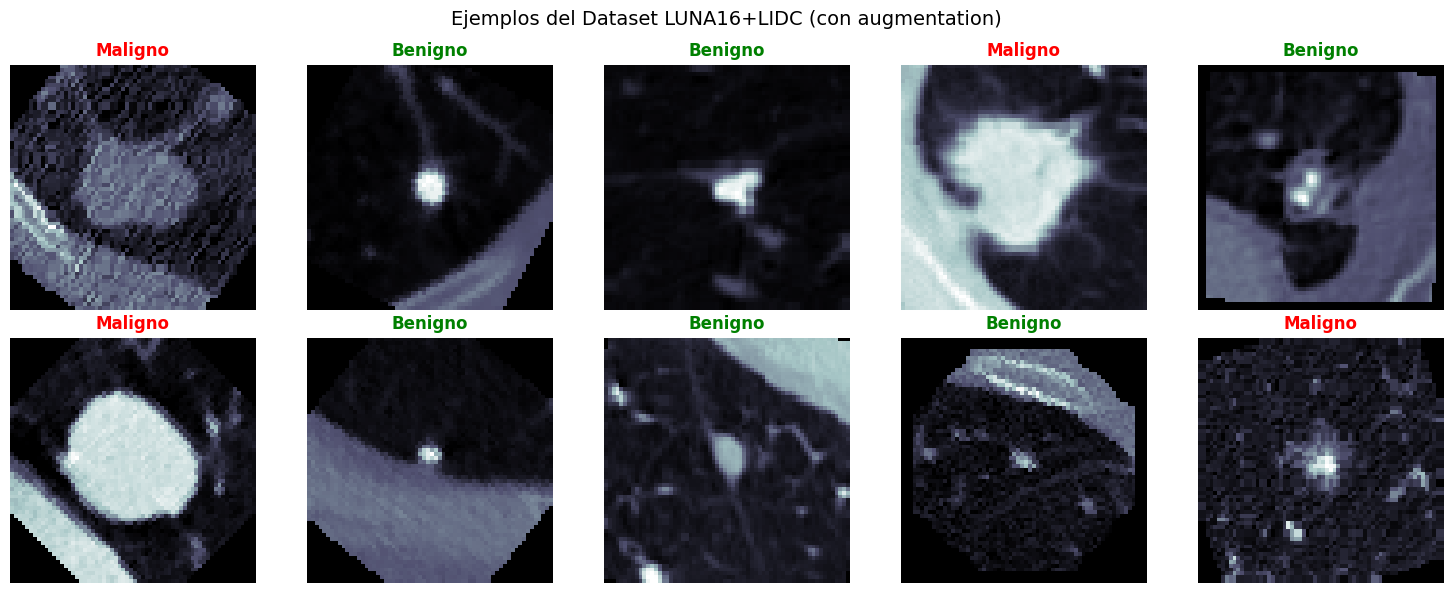

In [9]:
# Visualizar ejemplos con augmentation
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

class_names = ['Benigno', 'Maligno']
colors = ['green', 'red']

for i in range(10):
    idx = i * (len(train_dataset) // 10)
    patch, label = train_dataset[idx]
    
    axes[i].imshow(patch.squeeze().numpy(), cmap='bone')
    axes[i].set_title(f'{class_names[label]}', color=colors[label], fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Ejemplos del Dataset LUNA16+LIDC (con augmentation)', fontsize=14)
plt.tight_layout()
plt.show()

---

## 4. Modelos: EfficientNet-B0 y DenseNet121

Usamos modelos pre-entrenados de `timm` adaptados para imagenes grayscale.

In [10]:
def create_model(model_name, num_classes=2, pretrained=True):
    """
    Crea un modelo clasificador adaptado para grayscale
    
    Args:
        model_name: 'efficientnet_b0' o 'densenet121'
        num_classes: Numero de clases
        pretrained: Usar pesos pre-entrenados
    
    Returns:
        Modelo PyTorch
    """
    # Crear modelo con timm
    model = timm.create_model(
        model_name, 
        pretrained=pretrained, 
        num_classes=num_classes,
        in_chans=1  # Grayscale
    )
    
    return model


# Crear ambos modelos
models_dict = {
    'EfficientNet-B0': create_model('efficientnet_b0'),
    'DenseNet121': create_model('densenet121')
}

# Mostrar info de modelos
for name, model in models_dict.items():
    n_params = sum(p.numel() for p in model.parameters())
    n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{name}:")
    print(f"  Parametros totales: {n_params:,}")
    print(f"  Parametros entrenables: {n_trainable:,}")
    print()

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

c:\Users\Poney\Desktop\Imagenes Biomedicas\.venv\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Poney\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

EfficientNet-B0:
  Parametros totales: 4,009,534
  Parametros entrenables: 4,009,534

DenseNet121:
  Parametros totales: 6,949,634
  Parametros entrenables: 6,949,634



c:\Users\Poney\Desktop\Imagenes Biomedicas\.venv\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Poney\.cache\huggingface\hub\models--timm--densenet121.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


---

## 5. Entrenamiento

Entrenamos ambos modelos y comparamos resultados.

In [11]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Entrena una epoca"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for patches, labels in loader:
        patches = patches.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(patches)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), correct / total


def validate(model, loader, criterion, device):
    """Valida el modelo"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for patches, labels in loader:
            patches = patches.to(device)
            labels = labels.to(device)
            
            outputs = model(patches)
            loss = criterion(outputs, labels)
            probs = F.softmax(outputs, dim=1)[:, 1]
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calcular AUC
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except:
        auc = 0.5
    
    return total_loss / len(loader), correct / total, auc


def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-4, 
                model_name="model", save_path=None):
    """
    Entrena el clasificador con early stopping
    
    Returns:
        history: Historial de entrenamiento
        best_val_auc: Mejor AUC en validacion
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_auc': []
    }
    
    best_val_auc = 0
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, val_auc = validate(model, val_loader, criterion, device)
        
        # Scheduler
        scheduler.step()
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        
        # Guardar mejor modelo
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
            if save_path:
                torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
        
        print(f"Epoch {epoch+1:02d}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2%} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2%}, AUC: {val_auc:.3f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"[INFO] Early stopping at epoch {epoch+1}")
            break
    
    return history, best_val_auc


print("Funciones de entrenamiento definidas")

Funciones de entrenamiento definidas


In [12]:
# ============================================================
# ENTRENAR AMBOS MODELOS
# ============================================================
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4

results = {}

for model_name, model in models_dict.items():
    print("="*60)
    print(f"Entrenando {model_name}")
    print("="*60)
    
    # Path para guardar pesos
    save_path = os.path.join(weights_dir, f'{model_name.lower().replace("-", "_")}_nodules.pth')
    
    # Reinicializar modelo (evitar contaminacion entre entrenamientos)
    if model_name == 'EfficientNet-B0':
        model = create_model('efficientnet_b0')
    else:
        model = create_model('densenet121')
    
    # Entrenar
    history, best_auc = train_model(
        model, train_loader, val_loader,
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE,
        model_name=model_name,
        save_path=save_path
    )
    
    results[model_name] = {
        'history': history,
        'best_val_auc': best_auc,
        'save_path': save_path
    }
    
    print(f"\n[OK] {model_name} - Mejor Val AUC: {best_auc:.3f}")
    print(f"    Modelo guardado: {save_path}\n")

Entrenando EfficientNet-B0
Epoch 01/25: Train Loss: 6.0770, Acc: 50.42% | Val Loss: 4.6607, Acc: 50.00%, AUC: 0.554
Epoch 02/25: Train Loss: 5.5548, Acc: 50.42% | Val Loss: 3.3935, Acc: 59.09%, AUC: 0.488
Epoch 03/25: Train Loss: 5.1744, Acc: 56.30% | Val Loss: 3.2636, Acc: 68.18%, AUC: 0.587
Epoch 04/25: Train Loss: 3.9909, Acc: 57.98% | Val Loss: 2.8739, Acc: 59.09%, AUC: 0.620
Epoch 05/25: Train Loss: 3.6212, Acc: 57.98% | Val Loss: 2.4461, Acc: 59.09%, AUC: 0.661
Epoch 06/25: Train Loss: 2.6426, Acc: 67.23% | Val Loss: 3.3501, Acc: 63.64%, AUC: 0.612
Epoch 07/25: Train Loss: 3.8364, Acc: 56.30% | Val Loss: 3.5499, Acc: 68.18%, AUC: 0.723
Epoch 08/25: Train Loss: 4.3120, Acc: 60.50% | Val Loss: 3.9589, Acc: 63.64%, AUC: 0.682
Epoch 09/25: Train Loss: 1.9553, Acc: 73.11% | Val Loss: 3.9657, Acc: 54.55%, AUC: 0.640
Epoch 10/25: Train Loss: 2.3797, Acc: 69.75% | Val Loss: 3.7845, Acc: 59.09%, AUC: 0.674
Epoch 11/25: Train Loss: 2.2239, Acc: 75.63% | Val Loss: 3.6565, Acc: 63.64%, AUC: 

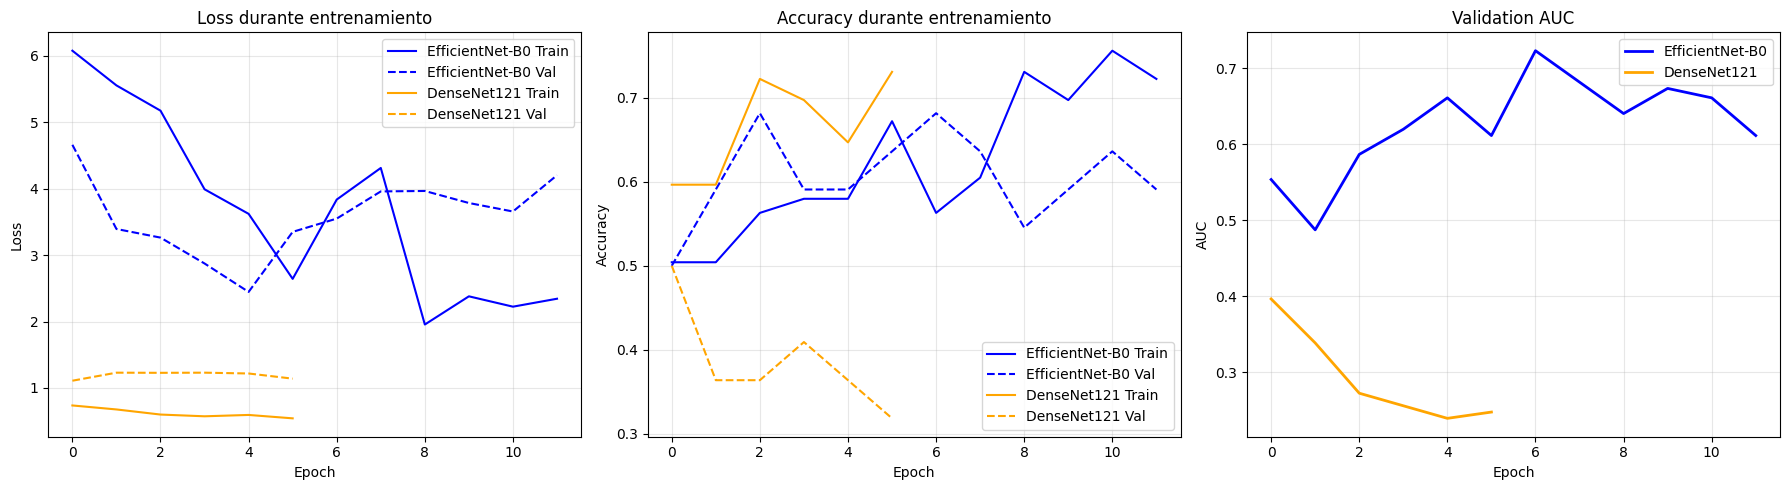


Resumen de entrenamiento:
  EfficientNet-B0: Best Val AUC = 0.723
  DenseNet121: Best Val AUC = 0.397


In [13]:
# Visualizar curvas de entrenamiento comparativas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = {'EfficientNet-B0': 'blue', 'DenseNet121': 'orange'}

# Loss
for model_name, data in results.items():
    history = data['history']
    axes[0].plot(history['train_loss'], label=f'{model_name} Train', 
                 color=colors[model_name], linestyle='-')
    axes[0].plot(history['val_loss'], label=f'{model_name} Val', 
                 color=colors[model_name], linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss durante entrenamiento')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
for model_name, data in results.items():
    history = data['history']
    axes[1].plot(history['train_acc'], label=f'{model_name} Train', 
                 color=colors[model_name], linestyle='-')
    axes[1].plot(history['val_acc'], label=f'{model_name} Val', 
                 color=colors[model_name], linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy durante entrenamiento')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# AUC
for model_name, data in results.items():
    history = data['history']
    axes[2].plot(history['val_auc'], label=f'{model_name}', 
                 color=colors[model_name], linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Validation AUC')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Resumen
print("\nResumen de entrenamiento:")
for model_name, data in results.items():
    print(f"  {model_name}: Best Val AUC = {data['best_val_auc']:.3f}")

---

## 6. Evaluacion en Test Set

Evaluamos ambos modelos en el conjunto de test y comparamos metricas.

In [14]:
def evaluate_on_test(model, test_loader, device):
    """
    Evalua modelo en test set
    
    Returns:
        y_true, y_pred, y_prob
    """
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    
    with torch.no_grad():
        for patches, labels in test_loader:
            patches = patches.to(device)
            
            outputs = model(patches)
            probs = F.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(probs[:, 1].cpu().numpy())
    
    return np.array(y_true), np.array(y_pred), np.array(y_prob)


# Evaluar ambos modelos en test
test_results = {}

for model_name, data in results.items():
    print(f"\n{'='*60}")
    print(f"Evaluacion: {model_name}")
    print('='*60)
    
    # Cargar mejor modelo
    if model_name == 'EfficientNet-B0':
        model = create_model('efficientnet_b0', pretrained=False)
    else:
        model = create_model('densenet121', pretrained=False)
    
    model.load_state_dict(torch.load(data['save_path']))
    model = model.to(device)
    
    # Evaluar
    y_true, y_pred, y_prob = evaluate_on_test(model, test_loader, device)
    
    # Metricas
    accuracy = (y_true == y_pred).mean()
    auc = roc_auc_score(y_true, y_prob)
    
    print(f"\nResultados en Test ({len(y_true)} muestras):")
    print(f"  Accuracy: {accuracy:.2%}")
    print(f"  AUC: {auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Benigno', 'Maligno']))
    
    test_results[model_name] = {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'accuracy': accuracy,
        'auc': auc
    }


Evaluacion: EfficientNet-B0

Resultados en Test (23 muestras):
  Accuracy: 43.48%
  AUC: 0.377

Classification Report:
              precision    recall  f1-score   support

     Benigno       0.50      0.46      0.48        13
     Maligno       0.36      0.40      0.38        10

    accuracy                           0.43        23
   macro avg       0.43      0.43      0.43        23
weighted avg       0.44      0.43      0.44        23


Evaluacion: DenseNet121

Resultados en Test (23 muestras):
  Accuracy: 47.83%
  AUC: 0.469

Classification Report:
              precision    recall  f1-score   support

     Benigno       0.55      0.46      0.50        13
     Maligno       0.42      0.50      0.45        10

    accuracy                           0.48        23
   macro avg       0.48      0.48      0.48        23
weighted avg       0.49      0.48      0.48        23



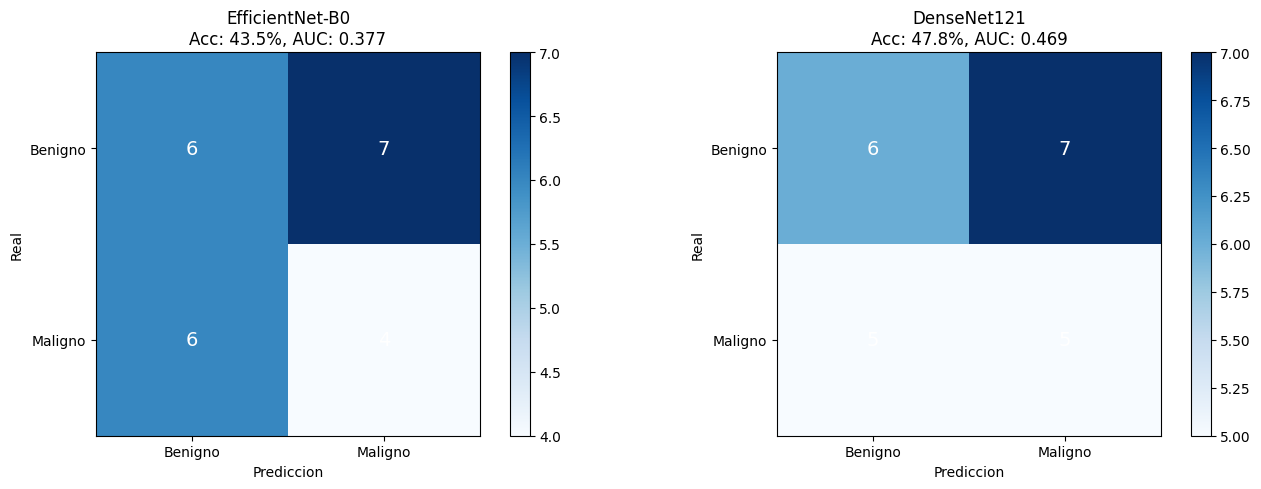

In [15]:
# Matrices de confusion comparativas
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (model_name, data) in enumerate(test_results.items()):
    cm = confusion_matrix(data['y_true'], data['y_pred'])
    
    im = axes[idx].imshow(cm, interpolation='nearest', cmap='Blues')
    axes[idx].figure.colorbar(im, ax=axes[idx])
    
    classes = ['Benigno', 'Maligno']
    axes[idx].set(xticks=np.arange(len(classes)),
                  yticks=np.arange(len(classes)),
                  xticklabels=classes, yticklabels=classes,
                  ylabel='Real',
                  xlabel='Prediccion')
    axes[idx].set_title(f'{model_name}\nAcc: {data["accuracy"]:.1%}, AUC: {data["auc"]:.3f}')
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            axes[idx].text(j, i, str(cm[i, j]),
                          ha="center", va="center",
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=14)

plt.tight_layout()
plt.show()

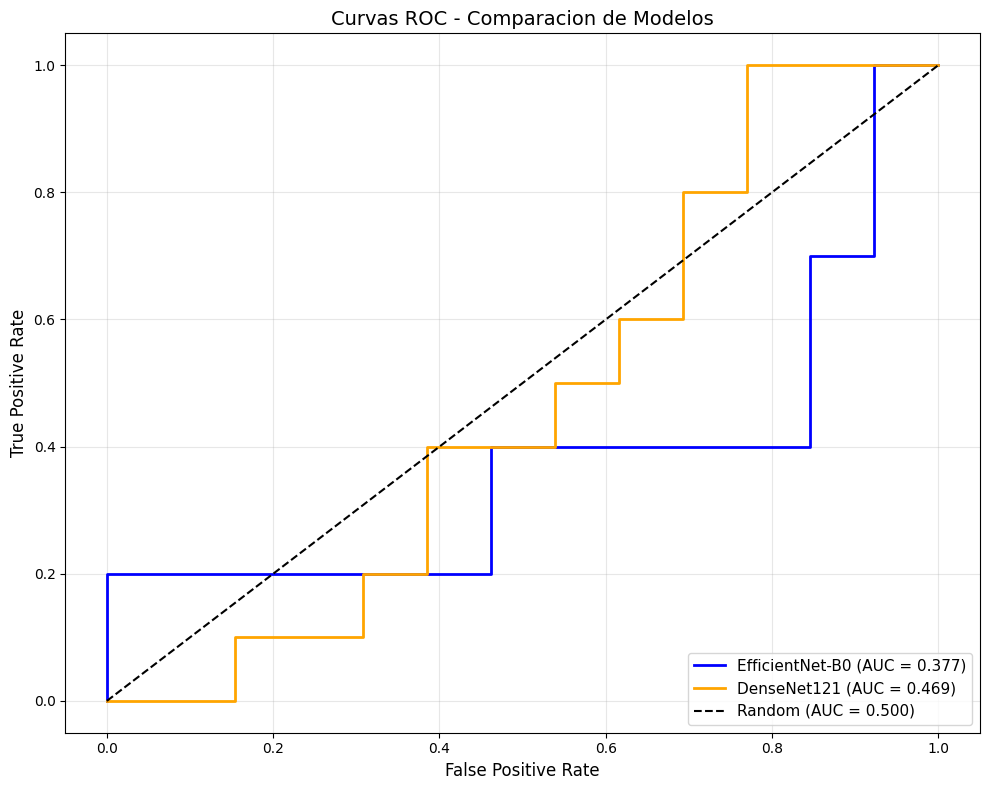


RESUMEN COMPARATIVO
Modelo                   Accuracy          AUC    Precision       Recall
------------------------------------------------------------
EfficientNet-B0            43.5%        0.377        0.364        0.400
DenseNet121                47.8%        0.469        0.417        0.500


In [16]:
# Curvas ROC comparativas
plt.figure(figsize=(10, 8))

colors = {'EfficientNet-B0': 'blue', 'DenseNet121': 'orange'}

for model_name, data in test_results.items():
    fpr, tpr, _ = roc_curve(data['y_true'], data['y_prob'])
    auc = data['auc']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', 
             color=colors[model_name], linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC - Comparacion de Modelos', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Tabla resumen
print("\n" + "="*60)
print("RESUMEN COMPARATIVO")
print("="*60)
print(f"{'Modelo':<20} {'Accuracy':>12} {'AUC':>12} {'Precision':>12} {'Recall':>12}")
print("-"*60)

for model_name, data in test_results.items():
    y_true, y_pred = data['y_true'], data['y_pred']
    # Precision y recall para clase maligna
    tp = ((y_pred == 1) & (y_true == 1)).sum()
    fp = ((y_pred == 1) & (y_true == 0)).sum()
    fn = ((y_pred == 0) & (y_true == 1)).sum()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    print(f"{model_name:<20} {data['accuracy']:>11.1%} {data['auc']:>12.3f} {precision:>12.3f} {recall:>12.3f}")

In [17]:
# Seleccionar mejor modelo
best_model_name = max(test_results.items(), key=lambda x: x[1]['auc'])[0]
best_model_auc = test_results[best_model_name]['auc']

print("\n" + "="*60)
print("RESUMEN FINAL")
print("="*60)

print(f"\nDataset LUNA16 + LIDC-IDRI:")
print(f"  Subsets utilizados: {available_subsets}")
print(f"  Total patches: {len(X)}")
print(f"  Train: {len(X_train)} ({len(train_uids)} pacientes)")
print(f"  Val: {len(X_val)} ({len(val_uids)} pacientes)")
print(f"  Test: {len(X_test)} ({len(test_uids)} pacientes)")

print(f"\nMejor modelo: {best_model_name}")
print(f"  AUC en Test: {best_model_auc:.3f}")
print(f"  Accuracy: {test_results[best_model_name]['accuracy']:.1%}")

print(f"\nModelos guardados en:")
for model_name, data in results.items():
    print(f"  {model_name}: {data['save_path']}")

print(f"\nMejoras respecto a ResNet18 baseline (AUC ~0.67):")
for model_name, data in test_results.items():
    improvement = (data['auc'] - 0.67) / 0.67 * 100
    print(f"  {model_name}: {'+' if improvement > 0 else ''}{improvement:.1f}%")


RESUMEN FINAL

Dataset LUNA16 + LIDC-IDRI:
  Subsets utilizados: [0, 1, 2, 3]
  Total patches: 164
  Train: 119 (86 pacientes)
  Val: 22 (18 pacientes)
  Test: 23 (19 pacientes)

Mejor modelo: DenseNet121
  AUC en Test: 0.469
  Accuracy: 47.8%

Modelos guardados en:
  EfficientNet-B0: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights\efficientnet_b0_nodules.pth
  DenseNet121: c:\Users\Poney\Desktop\Imagenes Biomedicas\weights\densenet121_nodules.pth

Mejoras respecto a ResNet18 baseline (AUC ~0.67):
  EfficientNet-B0: -43.7%
  DenseNet121: -30.0%
